# 0.0 Imports

## 0.1 Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import inflection

from IPython.core.display import HTML

from sklearn.cluster import KMeans
from sklearn import metrics as m
from sklearn.preprocessing import FunctionTransformer, MinMaxScaler, StandardScaler, OrdinalEncoder
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer 

from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

from umap import UMAP

## 0.2 Helper Functions



In [3]:
# Defining some plot settings
def jupyter_settings():
    %matplotlib inline
    #%pylab inline
    #matplotlib notebook
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()

jupyter_settings()

## 0.3 Data Loading



In [3]:
df0 = pd.read_csv('../data/raw/ecommerce.csv', encoding='ISO-8859-1', sep = ',')
# source https://www.kaggle.com/vik2012kvs/high-value-customers-identification
# other https://github.com/provezano/UK-High-Value-Customers-Identification/tree/main/data

## 0.4 Columns Description



### Attribute Description
- InvoiceNo Invoice number (A 6-digit integral number uniquely assigned to each transaction)
- StockCode Product (item) code
- Description Product (item) name
- Quantity The quantities of each product (item) per transaction
- InvoiceDate The day when each transaction was generated
- UnitPrice Unit price (Product price per unit)
- CustomerID Customer number (Unique ID assigned to each customer)
- Country Country name (The name of the country where each customer resides)

## 0.5 Solution Method

### IOT Input Output Visualizing

The aim is to build a data solution similar to this [draft](https://docs.google.com/spreadsheets/d/1zmBQAxvlx-nWgziQZmoL7lx-F1maMAMp5qlVD2c6AyA/edit?usp=sharing)

Situation: The organization will roll out a fidelity program (Insiders Program) to these customers. Customers should be segmented in a way that it is possible to find the most valuable customers. 

Inputs:
- Data from customer transactions (11-2016 ~ 12-2017)

Outputs:
 - Which customers are eligible to participate in the Insiders program?
 - How many customers will be part of the group?
 - What are the main characteristics of these customers?
 - What percentage of revenue contribution comes from Insiders?
 - What is the revenue expectation of this group for the coming months?
 - What are the conditions for a person to be eligible for Insiders?
 - What are the conditions for a person to be removed from Insiders?
 - Are there any guarantees that the Insiders Program customers' have indeed higher value than the rest of the customer base?
 - What actions can the marketing team take to increase revenue?

### Tasks:
- Which customers are eligible to participate in the Insiders program?
    - High Value
    - High Average Transaction Value
    - High Frequency (customer is frequently buying)
    - Low Recency (customer has bough recently)
    - High LTV
    - High Basket Size

- How many customers will be part of the group?
- What are the main characteristics of these customers?
- What percentage of revenue contribution comes from Insiders?
- What is the revenue expectation of this group for the coming months?
- What are the conditions for a person to be eligible for Insiders?
- What are the conditions for a person to be removed from Insiders?
- Are there any guarantees that the Insiders Program customers' have indeed higher value than the rest of the customer base?
- What actions can the marketing team take to increase revenue?

### Business Understanding and Metrics
- RFM Recency Frequency Monetary Analysis
    - Formula: ((Total distinct customers at end of period) - (Total new distinct customers acquired during period)) / (Total distinct customers at start of period)
- Average Customer Spend = Customers Annual Average Spend Per Purchase * Annual Purchase Frequency
- Average Transaction Value = Annual Revenue/ Invoces Raised


# 1.0 Data Description


In [4]:
df1 = pd.read_csv('../data/raw/ecommerce.csv', encoding='ISO-8859-1', sep = ',')

## 1.1 Rename Columns

In [5]:
cols_old = df1.columns.tolist()

cols_new = [inflection.underscore(col) for col in cols_old]
cols_new

['invoice_no',
 'stock_code',
 'description',
 'quantity',
 'invoice_date',
 'unit_price',
 'customer_id',
 'country',
 'unnamed: 8']

In [6]:
df1.rename(columns = dict(zip(cols_old, cols_new)), inplace = True )

## 1.2 Data Dimensions

In [7]:
print( 'Number of rows: {}'.format( df1.shape[0] ) )
print( 'Number of cols: {}'.format( df1.shape[1] ) )

Number of rows: 541909
Number of cols: 9


## 1.3 Data Types

In [8]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
unnamed: 8      float64
dtype: object

## 1.4 NA Check

In [9]:
df1.isna().sum()/df1.shape[0]*100

invoice_no        0.000000
stock_code        0.000000
description       0.268311
quantity          0.000000
invoice_date      0.000000
unit_price        0.000000
customer_id      24.926694
country           0.000000
unnamed: 8      100.000000
dtype: float64

In [10]:
df1.drop(columns=['unnamed: 8'], inplace = True)
df1.columns

Index(['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date',
       'unit_price', 'customer_id', 'country'],
      dtype='object')

## 1.5 NA Fillout

In [11]:
df1.dropna( subset = 'customer_id', how = 'any', axis = 0, inplace = True)

In [12]:
df1.isna().sum()

invoice_no      0
stock_code      0
description     0
quantity        0
invoice_date    0
unit_price      0
customer_id     0
country         0
dtype: int64

## 1.6 Changing Data Types


In [13]:
df1.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,17850.0,United Kingdom


In [14]:
df1.nunique()

invoice_no      22190
stock_code       3684
description      3896
quantity          436
invoice_date      305
unit_price        620
customer_id      4372
country            37
dtype: int64

In [15]:
df1['invoice_date'] = pd.to_datetime( df1['invoice_date'], format = '%d-%b-%y' )

df1['customer_id'] = df1['customer_id'].astype(int)

df1.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2016-11-29,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2016-11-29,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2016-11-29,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2016-11-29,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2016-11-29,3.39,17850,United Kingdom


In [16]:
df1.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
customer_id              int64
country                 object
dtype: object

## 1.7 Descriptive Statistics

### 1.7.1 Numerical Attributes

In [17]:
num_att = df1.select_dtypes(include= ['int','float'])
d1 = pd.DataFrame( num_att.min() ).T
d2 = pd.DataFrame( num_att.max() ).T
d3 = pd.DataFrame( num_att.max() - num_att.min() ).T
d4 = pd.DataFrame( num_att.mean() ).T
d5 = pd.DataFrame( num_att.median() ).T
d6 = pd.DataFrame( num_att.std() ).T
d7 = pd.DataFrame( num_att.skew() ).T
d8 = pd.DataFrame( num_att.kurtosis() ).T

desc = pd.concat( [d1, d2, d3, d4, d5, d6, d7, d8] ).T
desc.columns = ['min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis' ]
desc.style.format( "{:,.2f}" )

,min,max,range,mean,median,std,skew,kurtosis
quantity,"-80,995.00","80,995.00","161,990.00",12.06,5.00,248.69,0.18,"94,317.56"
unit_price,0.00,"38,970.00","38,970.00",3.46,1.95,69.32,452.22,"246,924.54"
customer_id,"12,346.00","18,287.00","5,941.00","15,287.69","15,152.00","1,713.60",0.03,-1.18


### 1.7.2 Categorical Attributes

# 2.0 Feature Engineering

## 2.1 Response Variable Mind Map

## 2.2 Hypothesis List

## 2.3 Selected Hypothesis:

**H1:** 

**H2:** 

**H3:** 

**H4:** 

**H5:** 

**H6:** 

**H7:** 

**H8:** 

**H9:** 

**H10:** 

**H11:** 

## 2.4 Feature Engineering

In [27]:
df2 = df1.copy()

In [28]:
# Recency
# days since last purchase (considering first day as day after last invoice)
df_recency = df2[['customer_id', 'invoice_date']].copy()
df_recency = df_recency.drop_duplicates(subset = 'customer_id', keep = 'last')
df_recency['recency'] =  (pd.to_datetime('2017-12-08') - df2['invoice_date']).dt.days
df_recency.drop(columns=['invoice_date'], inplace = True)

# Frequency
# nº of transactions a customer did
df_ref= df2[['invoice_no', 'customer_id']].groupby(['customer_id']).count().reset_index().rename(columns = {'invoice_no' : 'num_transactions'} ) #'invoice_date',  #['num_of_purchases']

# difference between firts and last transaction
# if nº purchases made = 1: date range =  today - first purchase date
# else last purchase - first purchase
func = lambda x: (x.max() - x.min() if (x.max() - x.min()).days != 0 else pd.to_datetime('2017-12-08') - x.min() ).days
df_date_range = df2[[ 'customer_id', 'invoice_date' ]].groupby('customer_id').agg( func ).reset_index().rename(columns = {'invoice_date' : 'date_range'})
df_ref = df_ref.merge(df_date_range, on = 'customer_id', how = 'left')
df_ref['frequency'] = df_ref['num_transactions']/df_ref['date_range']

# Monetary
# revenue
df_revenue = df2[['unit_price','quantity','customer_id']].copy()
df_revenue['customer_spend'] = df2['unit_price']*df2['quantity']

# sum and mean of revenue
df_revenue = df_revenue[['customer_id', 'customer_spend']].groupby('customer_id').agg( ['sum', 'mean'] )#.to_flat_index() #.reset_index(level=['customer_id', 'customer_spend'])

df_revenue = pd.DataFrame( df_revenue.to_records() )
cols = {"('customer_spend', 'sum')" : "revenue",
       "('customer_spend', 'mean')" : "avg_ticket"}
df_revenue.rename(columns = cols, inplace = True ) 


In [336]:
# # Testing transformations
# df_recency = df2[['customer_id', 'invoice_date']].copy()
# df_recency = df_recency.drop_duplicates(subset = 'customer_id', keep = 'last')
# df_recency['recency'] =  (pd.to_datetime('2017-12-08') - df2['invoice_date']).dt.days
# df_recency.drop(columns=['invoice_date'], inplace = True)
# df_recency[df_recency['customer_id'] == 12347]

# nº of transactions a customer did
# df_ref= df2[['invoice_no', 'customer_id']].groupby(['customer_id']).count().reset_index().rename(columns = {'invoice_no' : 'num_transactions'} ) #'invoice_date',  #['num_of_purchases']
# # difference between firts and last transaction
# # if nº purchases made = 1: date range =  today - first purchase date
# # else last purchase - first purchase
# func = lambda x: (x.max() - x.min() if (x.max() - x.min()).days != 0 else pd.to_datetime('2017-12-08') - x.min() ).days
# df_date_range = df2[[ 'customer_id', 'invoice_date' ]].groupby('customer_id').agg( func ).reset_index().rename(columns = {'invoice_date' : 'date_range'})
# df_ref = df_ref.merge(df_date_range, on = 'customer_id', how = 'left')
# df_ref['frequency'] = df_ref['num_transactions']/df_ref['date_range']
# df_ref.head()

# df_revenue = df2[['unit_price','quantity','customer_id']].copy()
# df_revenue['customer_spend'] = df2['unit_price']*df2['quantity']

# # # sum and mean of revenue

# df_revenue = df_revenue[['customer_id', 'customer_spend']].groupby('customer_id').agg( ['sum', 'mean'] )#.to_flat_index() #.reset_index(level=['customer_id', 'customer_spend'])

# df_revenue = pd.DataFrame( df_revenue.to_records() )
# cols = {"('customer_spend', 'sum')" : "revenue",
#        "('customer_spend', 'mean')" : "mean_spend"}
# df_revenue.rename(columns = cols, inplace = True ) 

# df_revenue[df_revenue.customer_id == 17850]
# df_revenue.head()

In [29]:
# Saving dataframe with all transformations
df_processed = df2[['customer_id', 'country']].drop_duplicates('customer_id')
df_processed = df_processed.merge( df_recency, how = 'left',  on = 'customer_id' )
df_processed = df_processed.merge( df_ref,     how = 'left',  on = 'customer_id')
df_processed = df_processed.merge( df_revenue, how = 'left',  on = 'customer_id')
df_processed.head()


,customer_id,country,recency,num_transactions,date_range,frequency,revenue,avg_ticket
0,17850,United Kingdom,303,312,71,4.394366,5288.63,16.950737
1,13047,United Kingdom,32,196,342,0.573099,3079.10,15.709694
2,12583,France,3,251,371,0.676550,7187.34,28.634821
3,13748,United Kingdom,96,28,278,0.100719,948.25,33.866071
4,15100,United Kingdom,331,6,43,0.139535,635.10,105.850000


In [30]:
# df_processed.to_csv('../data/interim/df2_interim.csv', index = False)
df2 = df_processed.copy()

# 3.0 Variable Selection

# 4.0 Exploratory Data Analysis - Space Analysis

## 4.1 Univariate Analysis

### 4.1.1 Response Variable

### 4.1.2 Numerical Variables

### 4.1.3 Categorical Variables

## 4.2 Bivariate Analysis

### **H1.**

### **H2.**


### **H3.**

### **H4.**

### **H5.**

### **H6.**

### **H7.**

### **H8.**

### **H9.**

### **H10.**

## 4.3 Multivariate Analysis

### 4.3.1 Numerical Attributes

### 4.3.2 Categorical Attributes

# 5.0 Data Preparation

## 5.1 Numerical Variables Preparation

In [31]:
# df3 = pd.read_csv('../data/interim/df2_interim.csv')
df3 = df2.copy()

### 5.1.1 Rescaling

In [32]:
# df3.hist();
num_att = df3.select_dtypes(include= ['int','float'])
d1 = pd.DataFrame( num_att.min() ).T
d2 = pd.DataFrame( num_att.max() ).T
d3 = pd.DataFrame( num_att.max() - num_att.min() ).T
d4 = pd.DataFrame( num_att.mean() ).T
d5 = pd.DataFrame( num_att.median() ).T
d6 = pd.DataFrame( num_att.std() ).T
d7 = pd.DataFrame( num_att.skew() ).T
d8 = pd.DataFrame( num_att.kurtosis() ).T

desc = pd.concat( [d1, d2, d3, d4, d5, d6, d7, d8] ).T
desc.columns = ['min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis' ]
desc.style.format( "{:,.2f}" )

,min,max,range,mean,median,std,skew,kurtosis
customer_id,"12,346.00","18,287.00","5,941.00","15,299.68","15,300.50","1,722.39",0.00,-1.20
recency,1.00,374.00,373.00,92.58,51.00,100.77,1.25,0.43
num_transactions,1.00,"7,983.00","7,982.00",93.05,42.00,232.47,18.15,486.23
date_range,1.00,374.00,373.00,183.38,188.00,118.73,0.03,-1.36
frequency,0.00,162.00,162.00,1.08,0.36,4.73,20.11,522.41
revenue,"-4,287.63","279,489.02","283,776.65","1,898.46",648.08,"8,219.35",21.71,607.15
avg_ticket,"-4,287.63","3,861.00","8,148.63",28.84,16.92,127.32,2.44,602.36


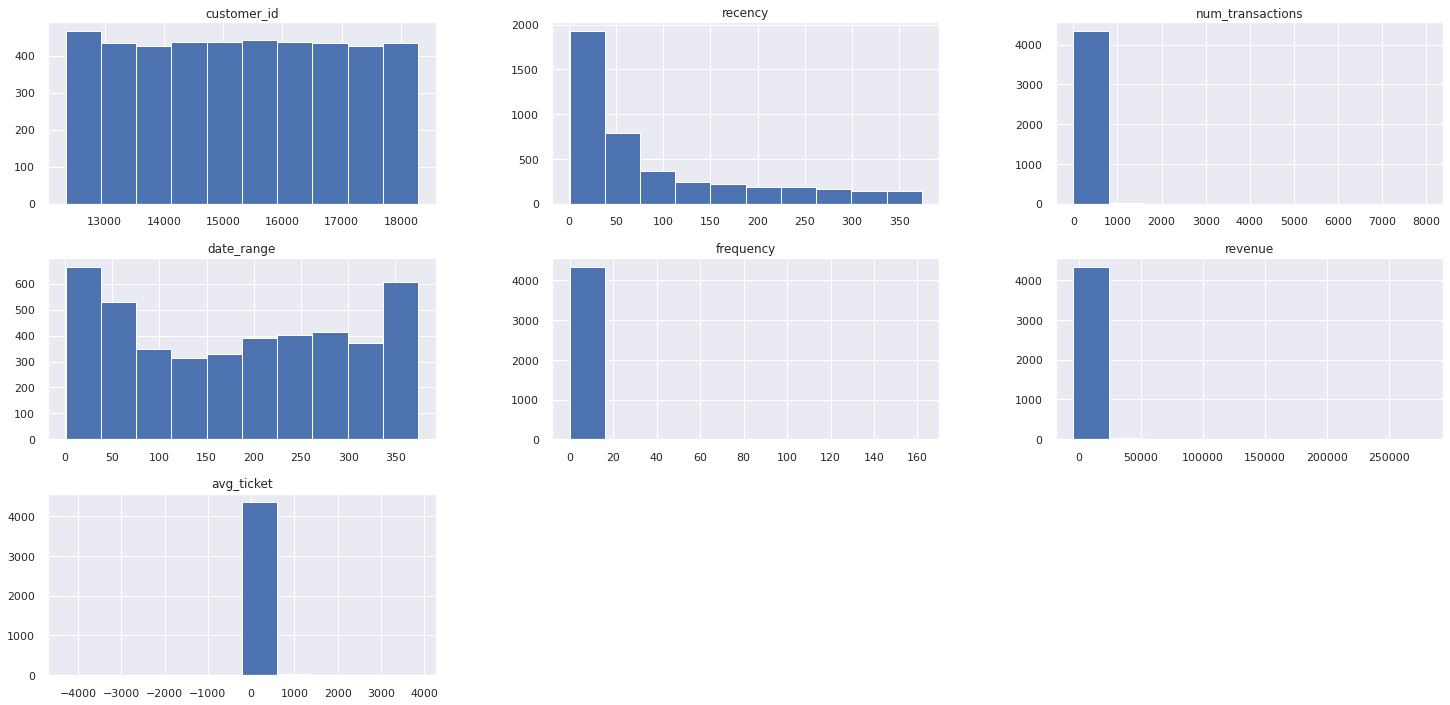

In [33]:
df3.hist();

In [34]:
df3_t = df3.drop(columns = 'customer_id').copy()

log_cols = ['recency']
std_cols = ['revenue', 'avg_ticket', 'date_range', 'num_transactions', 'frequency'] #+ log_cols
cat_cols = ['country']

log1p = FunctionTransformer(np.log1p)

# applying log and standard scaler to log cols
log_pipe = Pipeline(steps = [ ('log', log1p), ('std', StandardScaler()) ] )
ct_log = ColumnTransformer( transformers = [ ('log', log_pipe, log_cols) ] ) 

# applying std scaler to std cols
std_pipe = make_pipeline( (StandardScaler() ) )

# Label Encoding and std_scaler to catgorical columns
label_pipe = make_pipeline( OrdinalEncoder(), MinMaxScaler() )

preprocessor = ColumnTransformer( 
    transformers=[ ('log', log_pipe, log_cols), 
    ('std', std_pipe, std_cols), 
    ('label', label_pipe, cat_cols) ])
df_prep = preprocessor.fit_transform(df3_t)

df_prep[1]


array([-0.24821921,  0.14365808, -0.10312925,  1.33606857,  0.44288626,
       -0.10649868,  0.97222222])

# 6.0 Feature Selection

# 7.0 Model Testing

## 7.1 KMeans

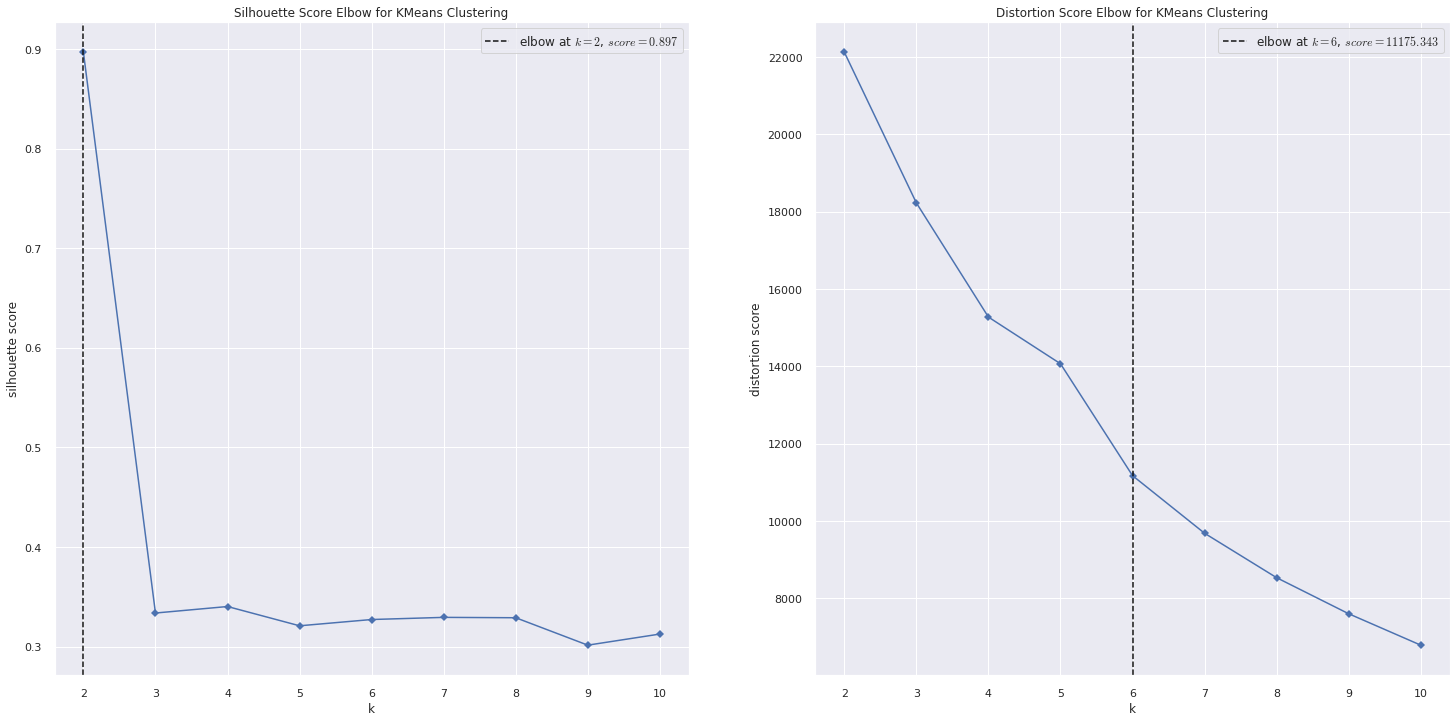

In [35]:
# defining the KMeans algorithm
kmeans = KMeans(random_state = 42)

# ploting 2 different metrics
fig, axes = plt.subplots(1, 2)

visualizer = KElbowVisualizer(kmeans, k=(2,11), timings = False, metric = 'silhouette', ax=axes[0] )
visualizer.fit(df_prep)
visualizer.finalize();

visualizer = KElbowVisualizer(kmeans, k=(2,11), timings = False, ax=axes[1] )
visualizer.fit(df_prep)
visualizer.finalize();

plt.show()

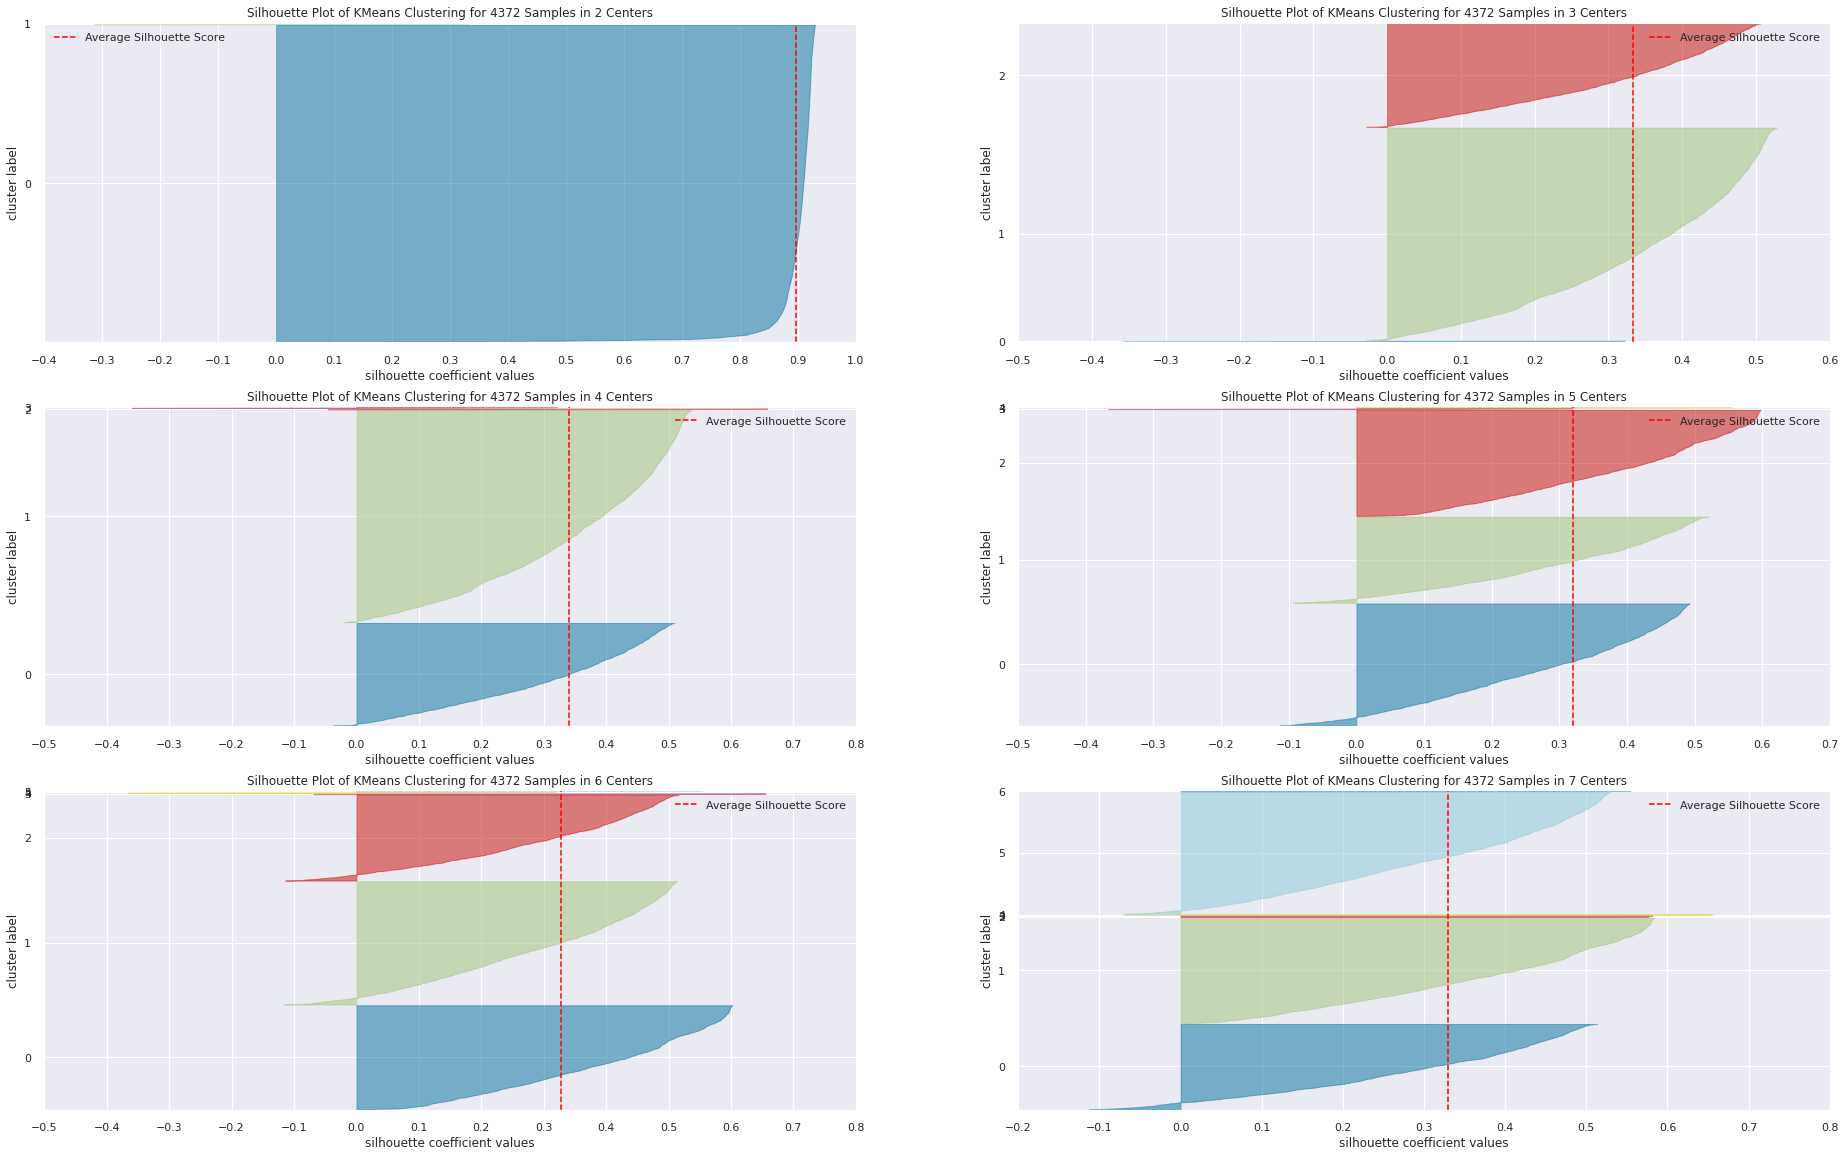

In [48]:
# Testing Clusters Silhouette
fig, axes = plt.subplots(3,2, figsize = (32,20))

# n_clusters from 2 to 7
for n in range(2,8):
    
    kmeans = KMeans(n_clusters = n, random_state = 42)
    # row and column for axes
    row, col = n//2 -1, n%2

    visualizer = SilhouetteVisualizer(kmeans, ax = axes[row][col], colors = 'yellowbrick' )
    visualizer.fit(df_prep)
    visualizer.finalize()

plt.show()

## 7.2 Comparing Model's Performances

# 8.0 Model Testing

# 9.0 Cluster Analysis

## 9.1 Visual Inspection - Metrics

In [36]:
# aplying a kmeans with n = 4
pipeline = make_pipeline( KMeans(n_clusters = 4, random_state = 42) )
labels = pipeline.fit_predict(df_prep)

# Evaluating Silhouette Score
m.silhouette_score(df_prep, labels)

0.34018199717287817

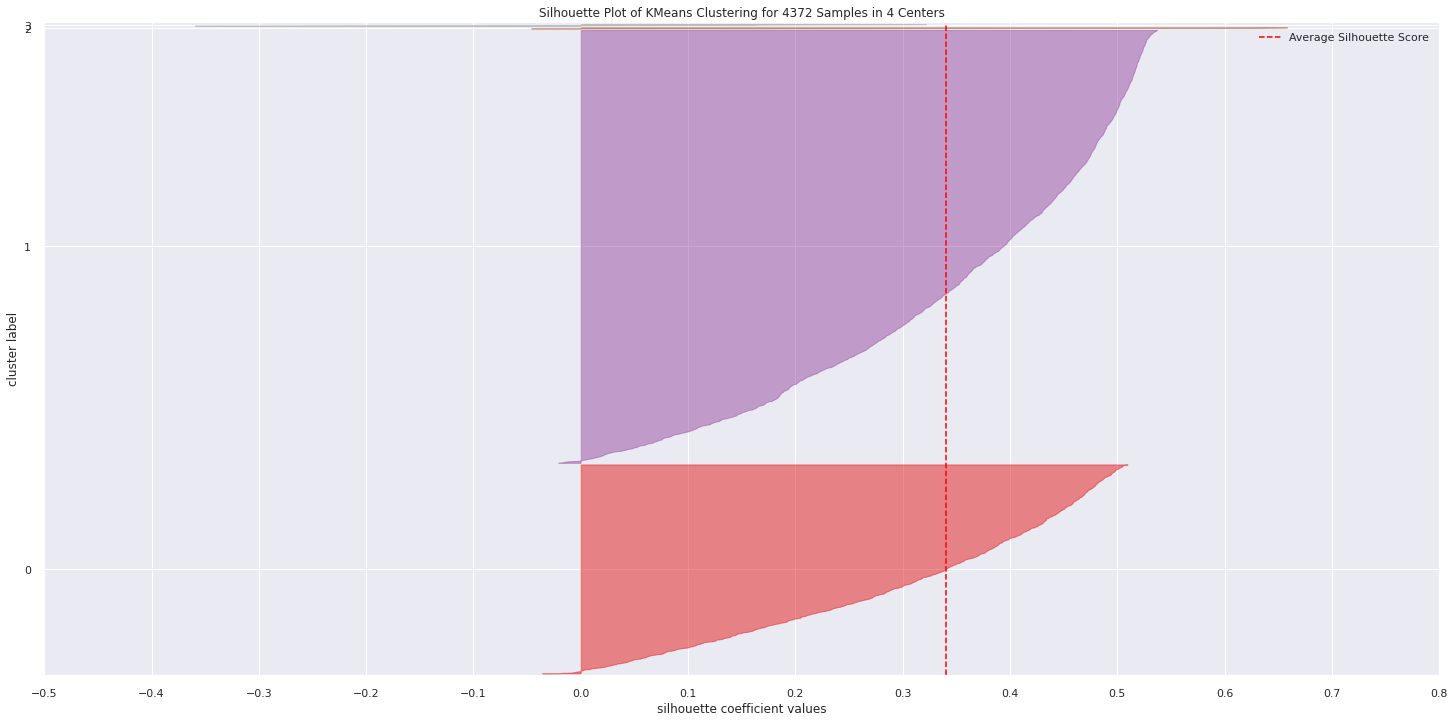

In [37]:
kmeans = KMeans(n_clusters = 4, random_state = 42)
visualizer = SilhouetteVisualizer( kmeans )
visualizer.fit(df_prep)
visualizer.show();

## 9.2 Pairploting Features

In [38]:
# columns from pipeline
cols = ['recency', 'revenue', 'avg_ticket', 'date_range', 'num_transactions', 'frequency','country']
df_viz = pd.DataFrame(df_prep, columns = cols)
df_viz['cluster'] = labels
df_viz.head()

,recency,revenue,avg_ticket,date_range,num_transactions,frequency,country,cluster
0,1.417933,0.412510,-0.093381,-0.946597,0.941929,0.700885,0.972222,1
1,-0.248219,0.143658,-0.103129,1.336069,0.442886,-0.106499,0.972222,0
2,-1.831603,0.643541,-0.001604,1.580339,0.679501,-0.084641,0.361111,0
3,0.560803,-0.115620,0.039487,0.796989,-0.279865,-0.206306,0.972222,1
4,1.484044,-0.153723,0.604912,-1.182445,-0.374511,-0.198105,0.972222,1


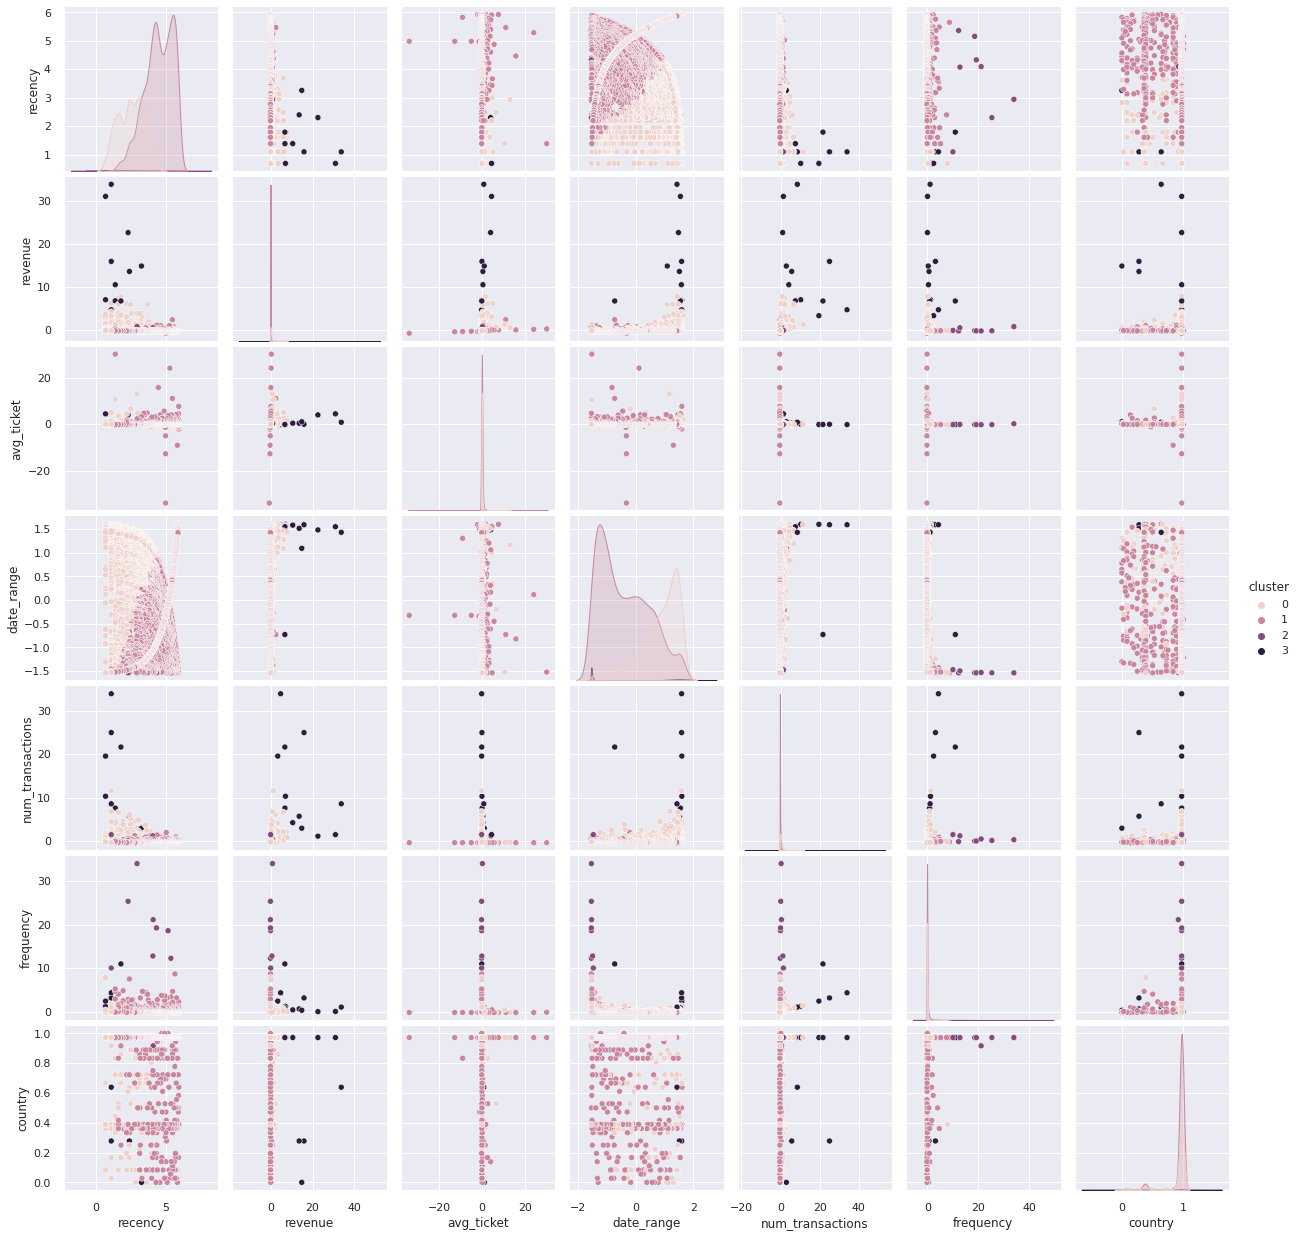

In [28]:
sns.pairplot(data = df_viz, hue = 'cluster' );

## 9.3 Visual Inspection - UMAP

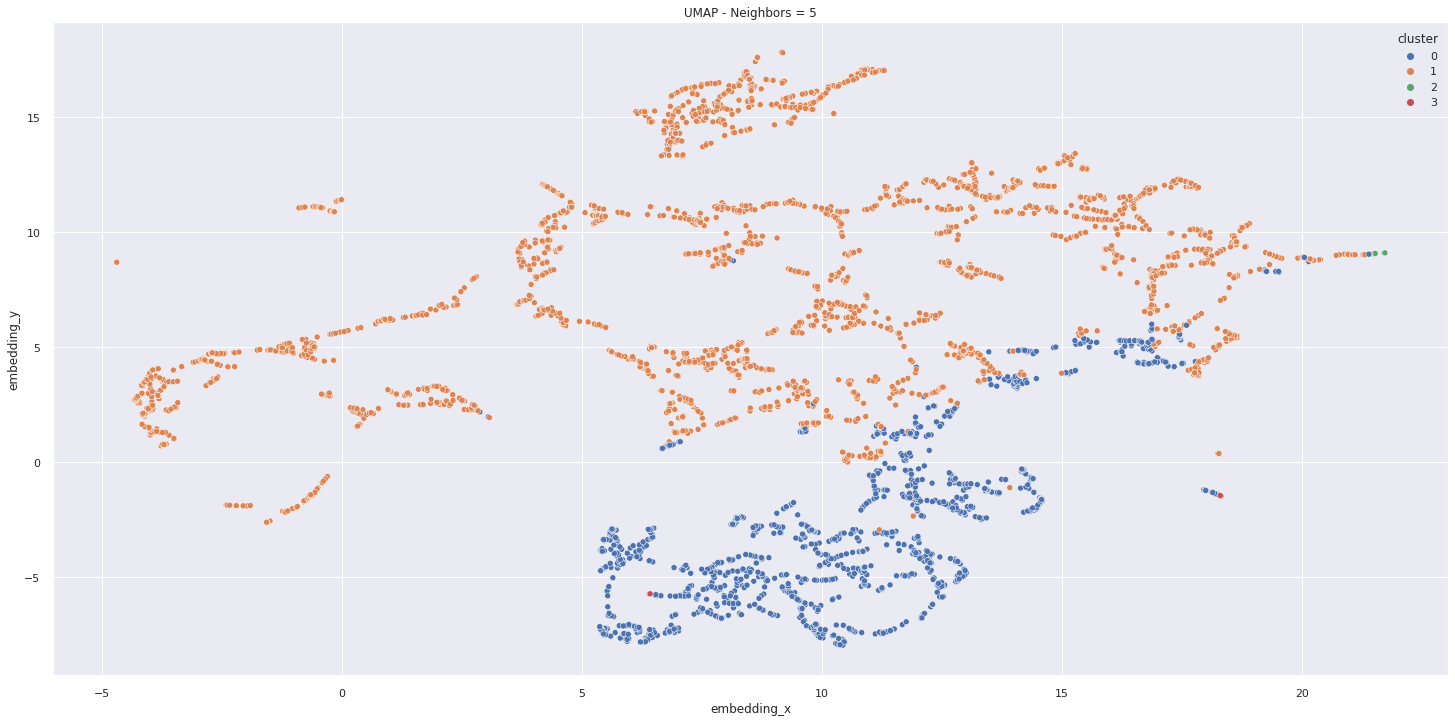

In [39]:
# Testing UMAP for 5, 15 and 25 neighbors
n_neighbors = 5
reducer = UMAP(n_neighbors = n_neighbors, random_state = 42)
embedding = reducer.fit_transform(df_prep)

df_viz['embedding_x'] = embedding[:,0]
df_viz['embedding_y'] = embedding[:,1]
plt.title('UMAP - Neighbors = {}'.format(n_neighbors) )
sns.scatterplot( data = df_viz, x = 'embedding_x', y = 'embedding_y', hue = 'cluster', palette = 'deep' );

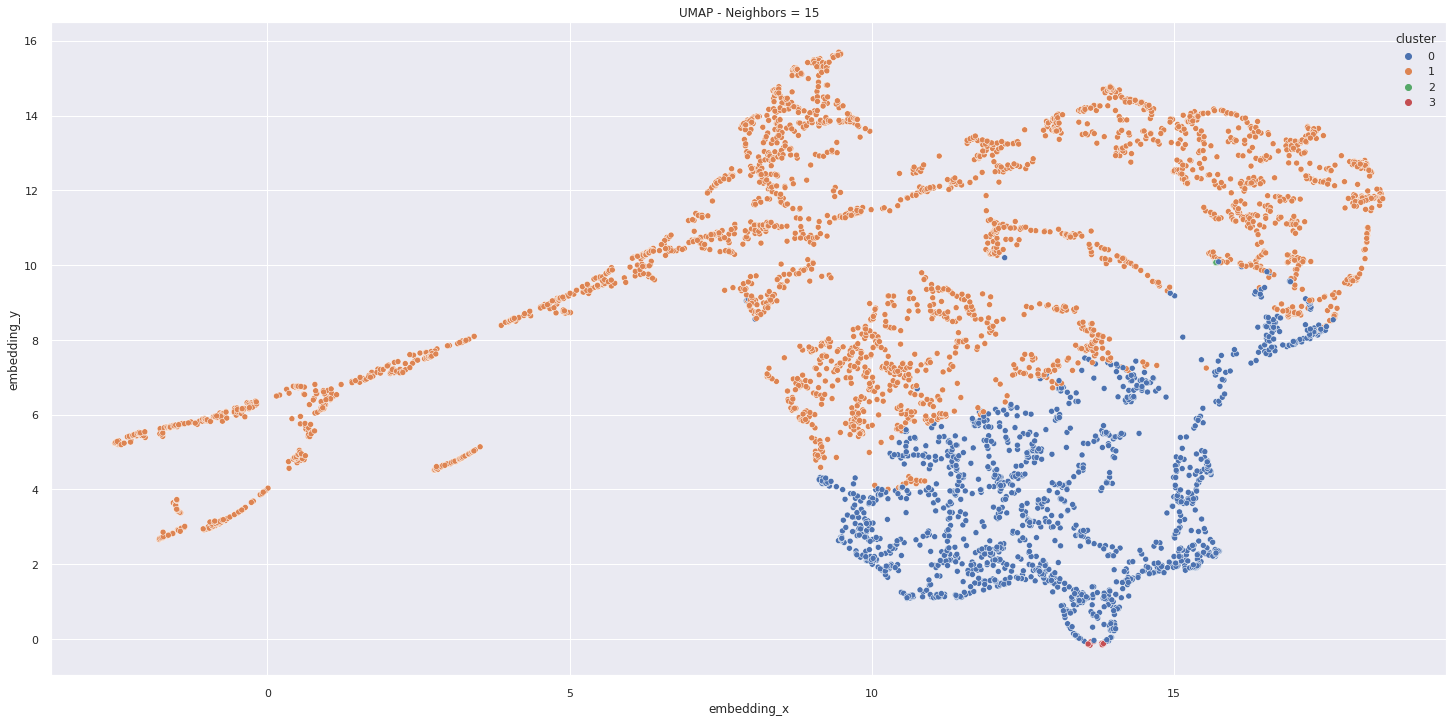

In [40]:
# Testing UMAP for 5, 15 and 25 neighbors
n_neighbors = 15
reducer = UMAP(n_neighbors = n_neighbors, random_state = 42)
embedding = reducer.fit_transform(df_prep)

df_viz['embedding_x'] = embedding[:,0]
df_viz['embedding_y'] = embedding[:,1]
plt.title('UMAP - Neighbors = {}'.format(n_neighbors) )
sns.scatterplot( data = df_viz, x = 'embedding_x', y = 'embedding_y', hue = 'cluster', palette = 'deep' );

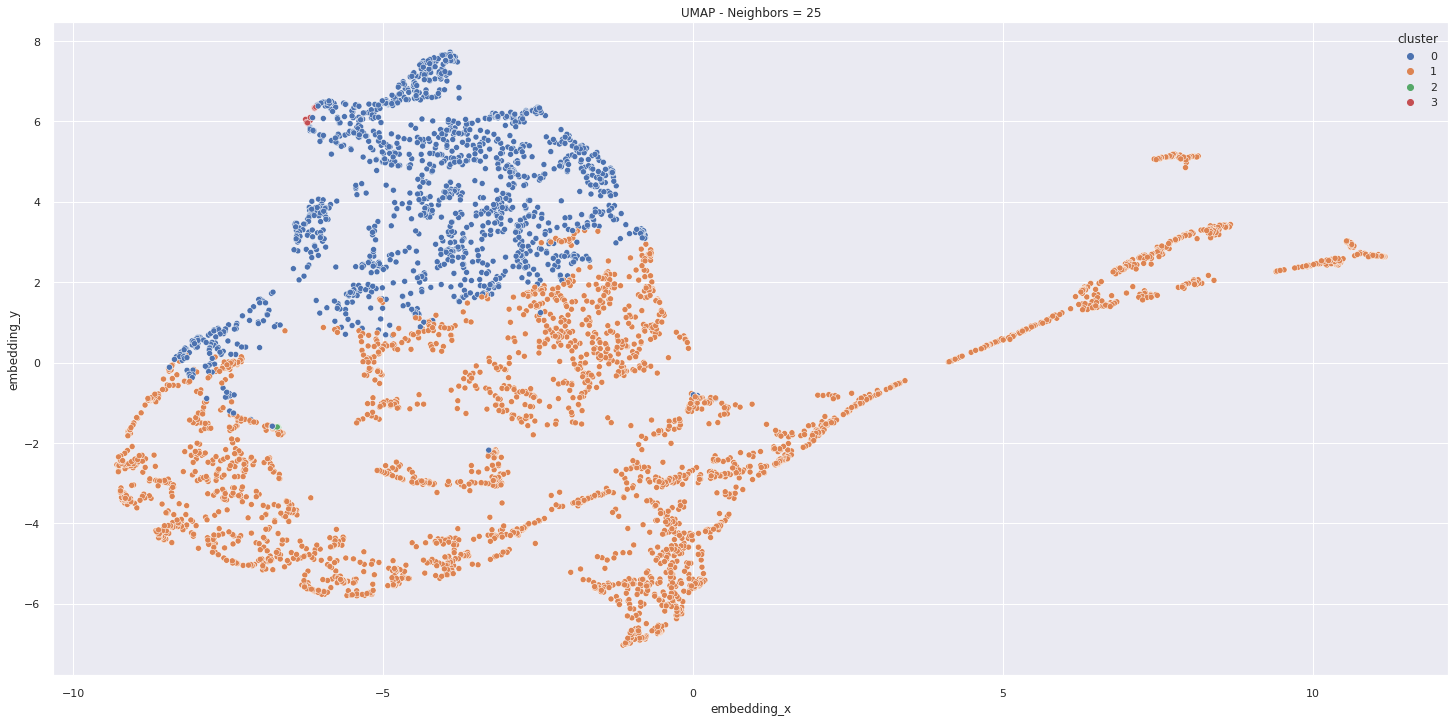

In [41]:
# Testing UMAP for 5, 15 and 25 neighbors
n_neighbors = 25
reducer = UMAP(n_neighbors = n_neighbors, random_state = 42)
embedding = reducer.fit_transform(df_prep)

df_viz['embedding_x'] = embedding[:,0]
df_viz['embedding_y'] = embedding[:,1]
plt.title('UMAP - Neighbors = {}'.format(n_neighbors) )
sns.scatterplot( data = df_viz, x = 'embedding_x', y = 'embedding_y', hue = 'cluster', palette = 'deep' );

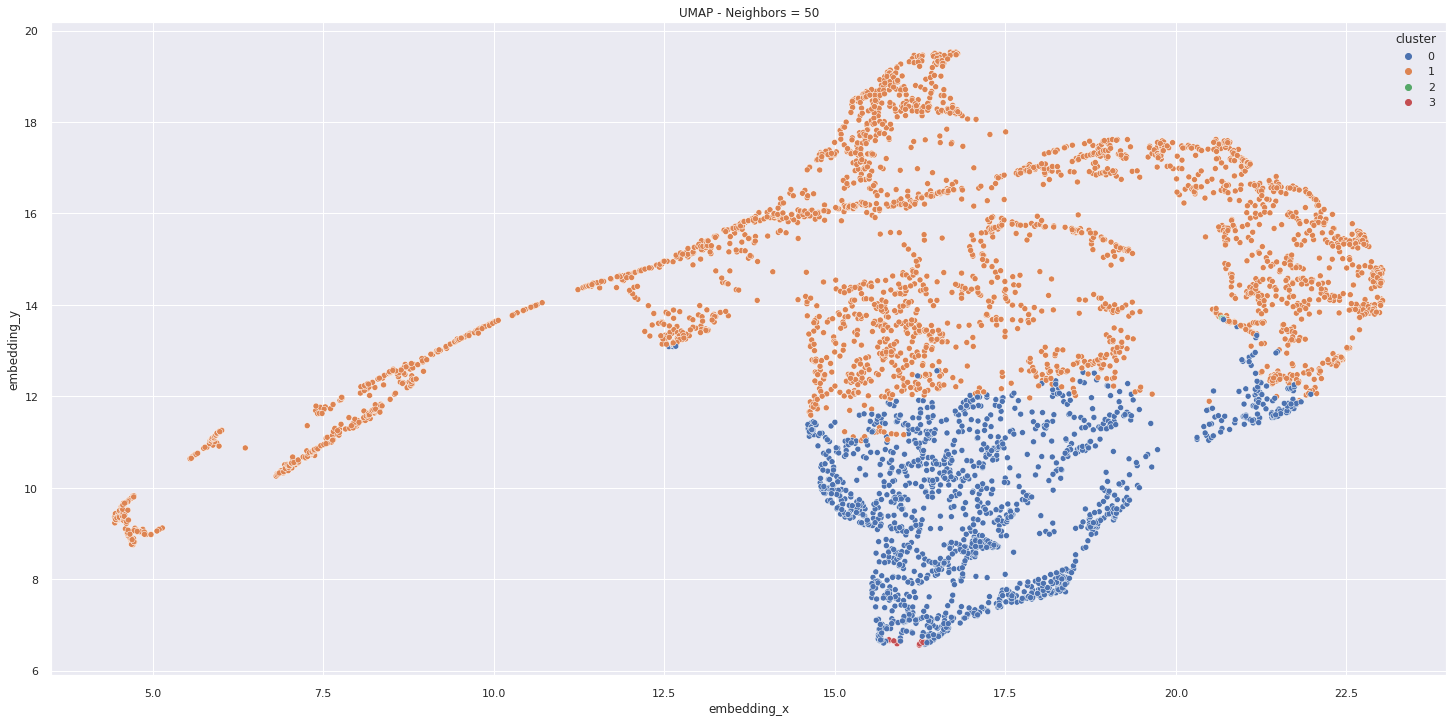

In [42]:
# Testing UMAP for 5, 15 and 25 neighbors
n_neighbors = 50
reducer = UMAP(n_neighbors = n_neighbors, random_state = 42)
embedding = reducer.fit_transform(df_prep)

df_viz['embedding_x'] = embedding[:,0]
df_viz['embedding_y'] = embedding[:,1]
plt.title('UMAP - Neighbors = {}'.format(n_neighbors) )
sns.scatterplot( data = df_viz, x = 'embedding_x', y = 'embedding_y', hue = 'cluster', palette = 'deep' );

We see that Clusters are probably not well separated yet in their high dimension feature space. Cluster 1 seems to be dominating the space and cluster 2 and 3 are still close to the other clusters

## 9.4 Business Perspective

In [43]:
# number of customers per cluster
n_cust = df3.copy()
n_cust['cluster'] = labels
n_cust = n_cust.groupby('cluster').count().reset_index().rename(columns = {'customer_id' : 'num_of_customers'})
n_cust['perc_of_customer'] = n_cust['num_of_customers']/n_cust['num_of_customers'].sum()*100
n_cust = n_cust[['cluster', 'num_of_customers', 'perc_of_customer']]

In [44]:
# calculating mean values for each cluster attribute

df_res = df3_t.copy()
# add cluster to df
df_res =pd.concat( [df_res, pd.DataFrame( { 'cluster' : labels} ) ], axis = 1 )
result = df_res.groupby('cluster').mean().reset_index()

# add nº of customers
result = result.merge( n_cust, on = 'cluster', how = 'inner')
result = result[['cluster', 'num_of_customers', 'perc_of_customer', 'num_transactions', 'date_range', 'frequency', 'recency', 'revenue', 'avg_ticket' ]]
result.sort_values('revenue', ascending = False )

,cluster,num_of_customers,perc_of_customer,num_transactions,date_range,frequency,recency,revenue,avg_ticket
3,3,12,0.274474,2845.583333,340.000000,10.978251,5.333333,118713.023333,140.072521
0,0,1417,32.410796,176.808045,280.625265,0.748925,16.998589,3422.738723,28.356257
2,2,8,0.182983,191.250000,2.750000,91.743056,75.750000,2112.021250,10.642976
1,1,2935,67.131747,41.095400,136.283816,0.947999,129.474617,684.358635,28.666895


In [45]:
# Generating a report of some attributes for each cluster
for i in range( len(np.unique(labels)) ):
    print('Cluster {}'.format(result.loc[i, 'cluster']))
    print(' - Number of customers {} (%{:.2f} of total)'.format(result.iloc[i, 1], result.iloc[i, 2]) )
    print(' - Average nº of transactions: {:.2f} '.format(result.iloc[i, 3]) )
    print(' - Average tenure in days {:.2f} '.format(result.iloc[i, 4]) )
    print(' - Average amount spent in total ${:,.2f} '.format(result.iloc[i, 7]) )
    print(' - Mean values for average ticket ${:,.2f} \n'.format(result.iloc[i, 8]) )

    

Cluster 0
 - Number of customers 1417 (%32.41 of total)
 - Average nº of transactions: 176.81 
 - Average tenure in days 280.63 
 - Average amount spent in total $3,422.74 
 - Mean values for average ticket $28.36 

Cluster 1
 - Number of customers 2935 (%67.13 of total)
 - Average nº of transactions: 41.10 
 - Average tenure in days 136.28 
 - Average amount spent in total $684.36 
 - Mean values for average ticket $28.67 

Cluster 2
 - Number of customers 8 (%0.18 of total)
 - Average nº of transactions: 191.25 
 - Average tenure in days 2.75 
 - Average amount spent in total $2,112.02 
 - Mean values for average ticket $10.64 

Cluster 3
 - Number of customers 12 (%0.27 of total)
 - Average nº of transactions: 2845.58 
 - Average tenure in days 340.00 
 - Average amount spent in total $118,713.02 
 - Mean values for average ticket $140.07 



# 10 Model Deployment